In [1]:
! cd ~/bench

In [111]:
from pathlib import Path
import polars as pl
import pickle
import joblib
import seaborn as sns

In [37]:
cfg = pl.Config()
cfg.set_fmt_str_lengths(150)

polars.config.Config

In [121]:
def prepare_results(root_dir):
    list_res = []
    for _path in root_dir.iterdir():
        if _path.stem != "minhash_index" and _path.is_file():
            with open(_path, "rb") as fp:
                res = joblib.load(fp)
                d = res["counts"].with_columns(pl.lit(_path.stem).alias("base_table"))
                d = d.filter(~pl.col("base_table").str.contains("depleted"))
            list_res.append(d)
    df = pl.concat(list_res)
    top_res = []
    for gidx, group in df.filter(pl.col("containment") > 0).group_by("base_table"):
        new_g = group.with_columns(
            pl.col("base_table")
            .str.replace("-yadl_col_to_embed", "")
            .str.replace("em_index_", "")
            .alias("base_table")
        )
        top_res.append(
            new_g.top_k(by="containment", k=100).with_row_count("rank", offset=1)
        )
    df_top = pl.concat(top_res)
    return df_top


def plot_results(df, tag):
    ax = sns.lineplot(
        data=df,
        x="rank",
        y="containment",
        hue="base_table",
    )

    ax.axvline(30, alpha=0.5)
    ax.set_title(tag)

# Binary update

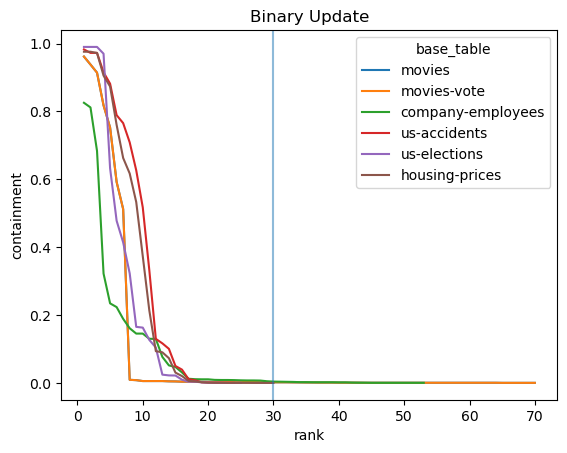

In [122]:
root_dir = Path(
    "/home/soda/rcappuzz/work/benchmark-join-suggestions/data/metadata/_indices/binary_update"
)
df_top = prepare_results(root_dir)
plot_results(df_top, "Binary Update")

# Wordnet full

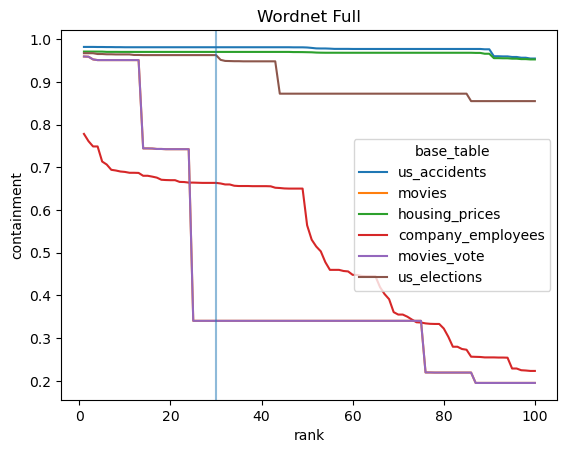

In [118]:
root_dir = Path(
    "/home/soda/rcappuzz/work/benchmark-join-suggestions/data/metadata/_indices/wordnet_full"
)
df_top = prepare_results(root_dir)
plot_results(df_top, "Wordnet Full")

# Open data US

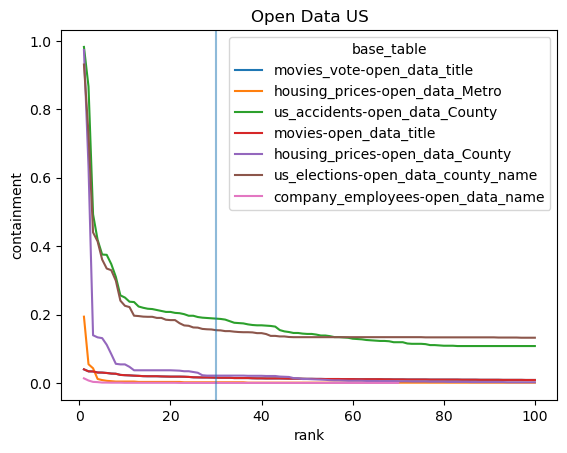

In [123]:
root_dir = Path(
    "/home/soda/rcappuzz/work/benchmark-join-suggestions/data/metadata/_indices/open_data_us"
)
df_top = prepare_results(root_dir)
plot_results(df_top, "Open Data US")